In [55]:
# Import ggplot2 and dplyr for better visualization of large data sets
library(ggplot2)
library(dplyr)
library(GGally)
library(car)
library(MASS)
library(boot)
library(effects)

In [ ]:
df <- read.csv("combined_midwest_data_with_dup.csv")
attach(df)
dim(df)

[1] 39157    57

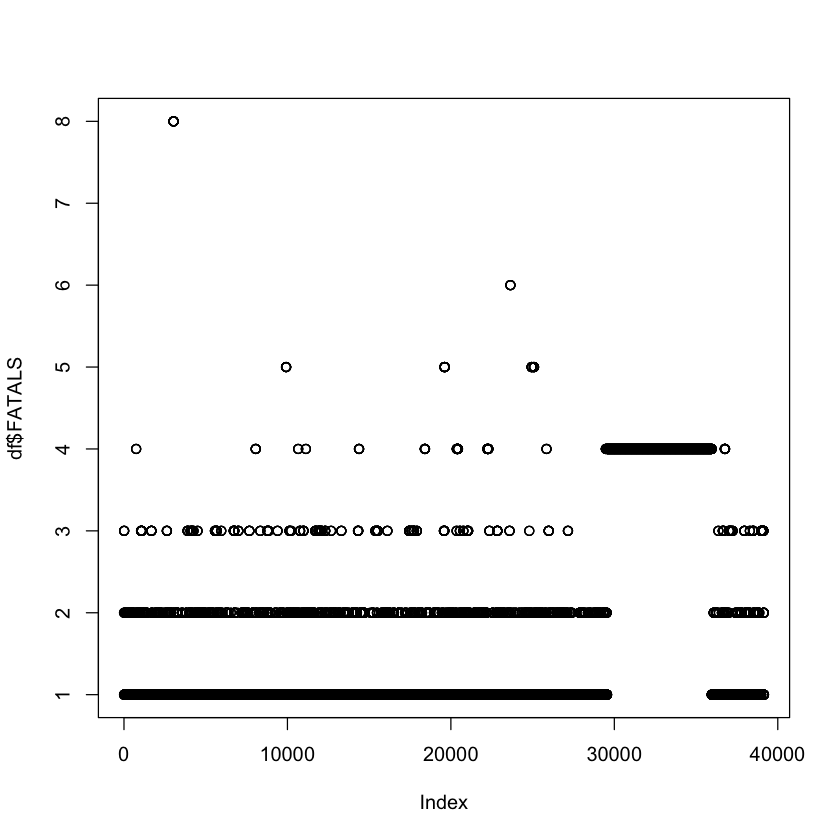

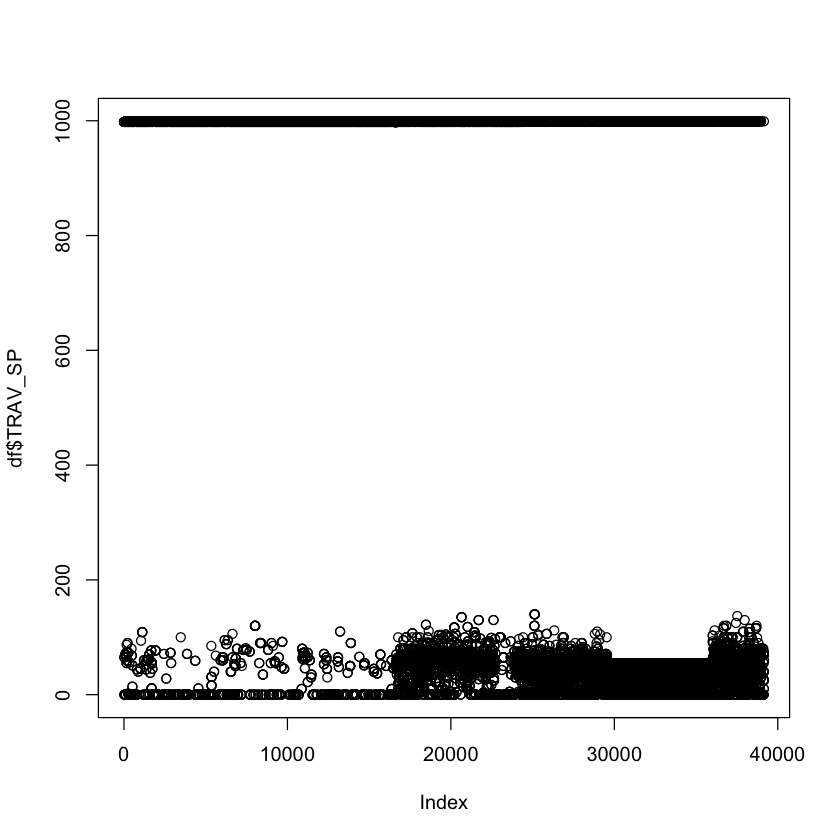

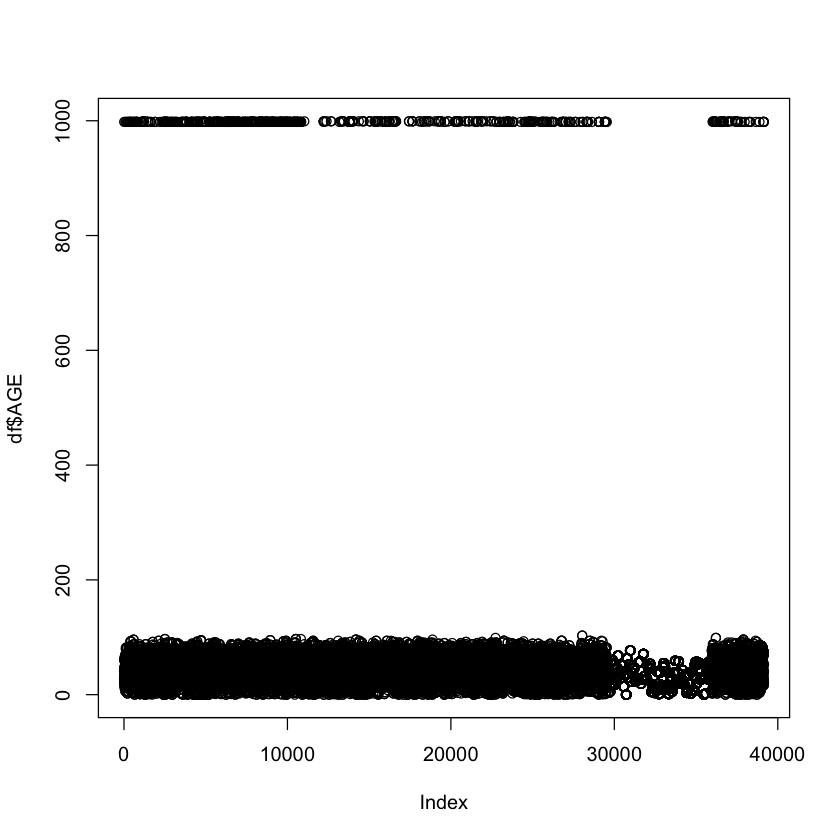

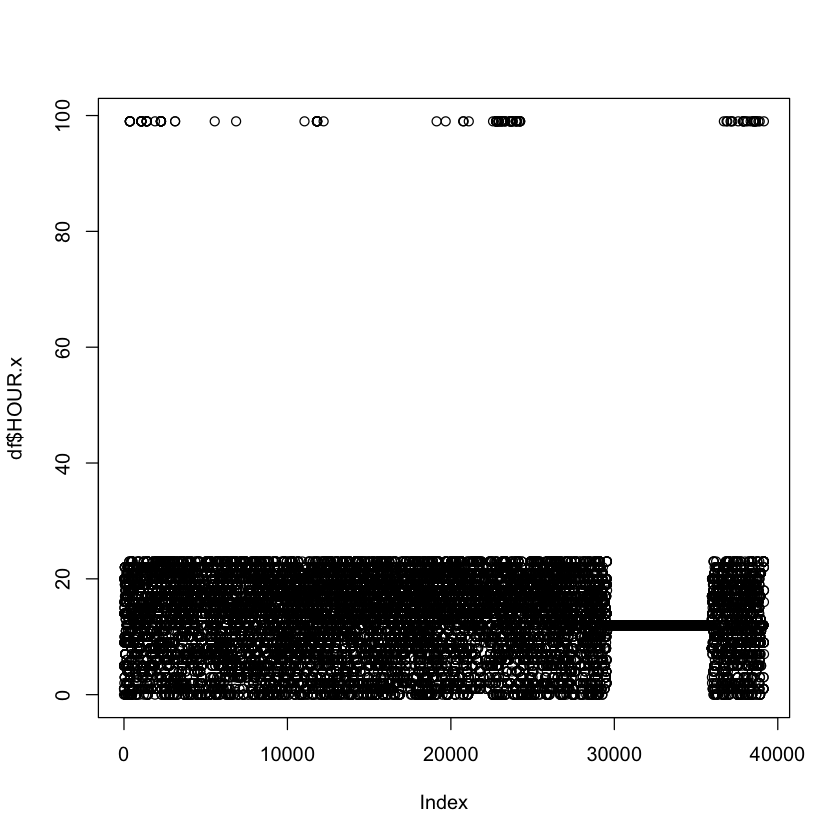

In [4]:
# Show the variables 
# Response: (FATALS)
# Categorical: (RUR-URBAN), (LGT_CONDNAME), (ROUTENAME)
# Continuous:(TRAV_SP) (AGE) (HOUR) 

# Continuous Variable Plots
plot(df$FATALS)
plot(df$TRAV_SP)
plot(df$AGE)
plot(df$HOUR.x)

### Plots

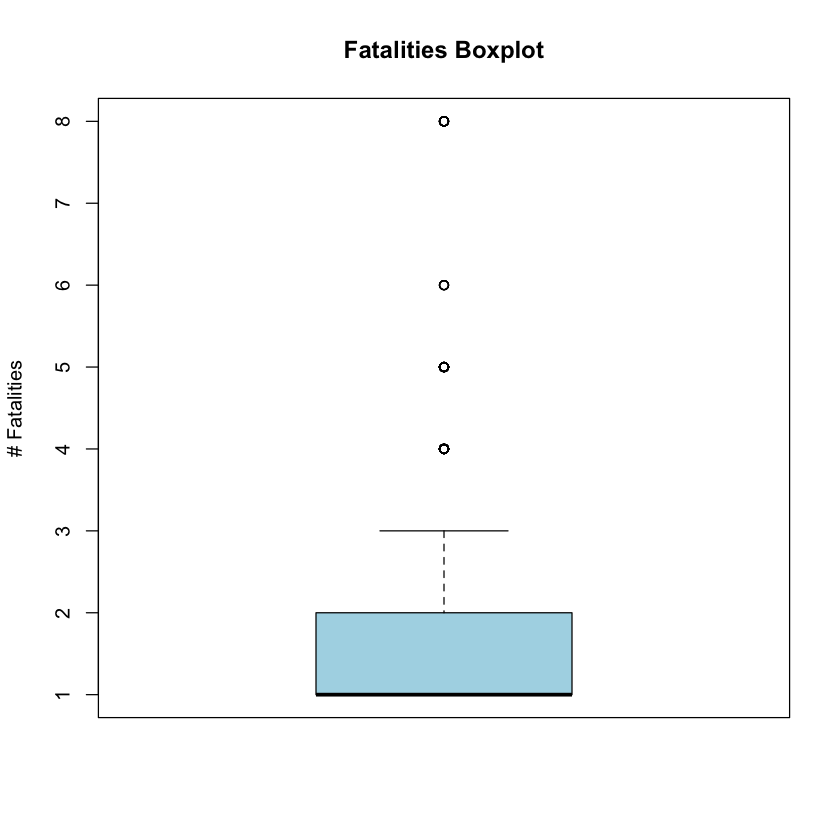

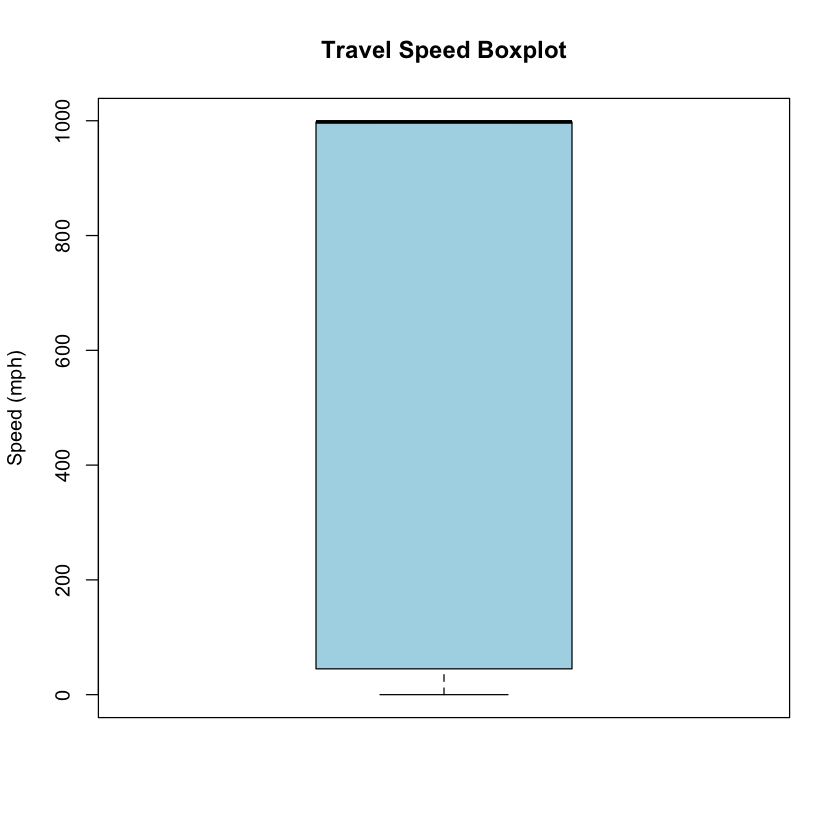

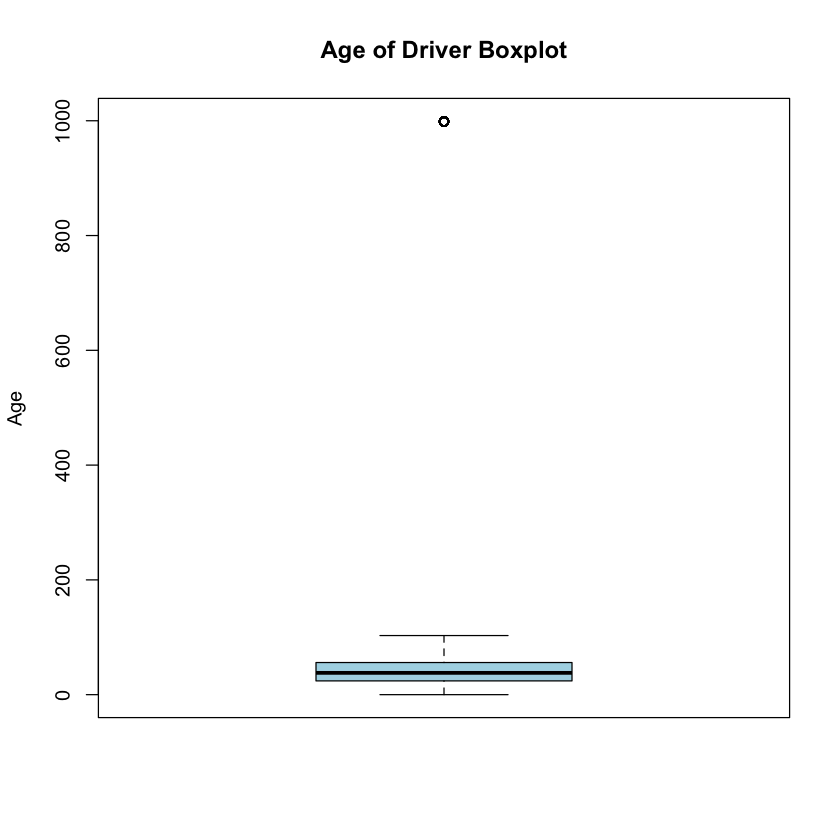

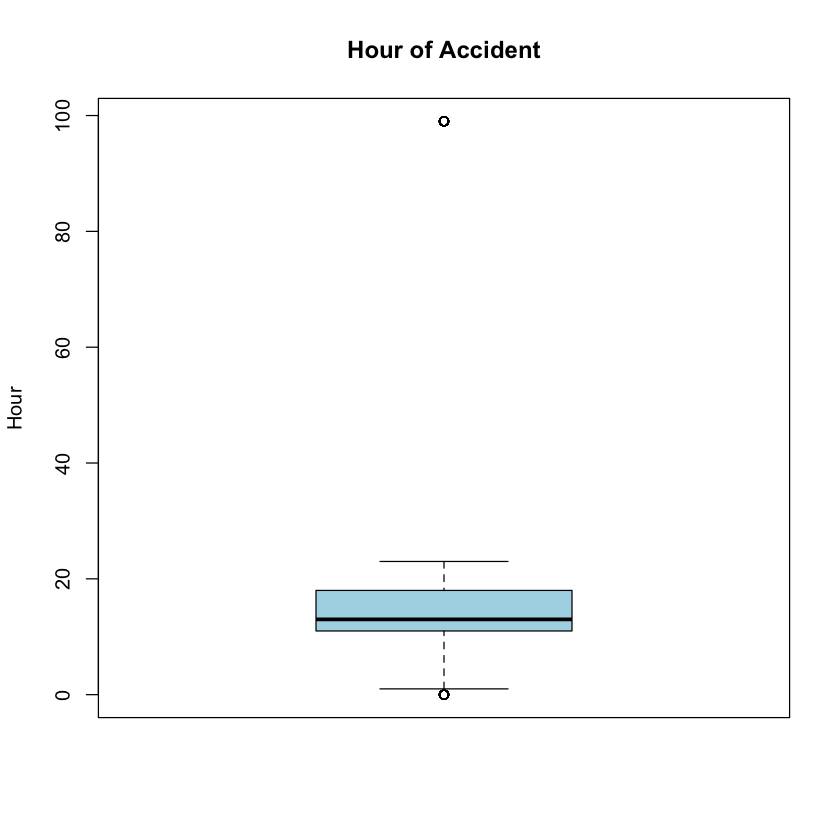

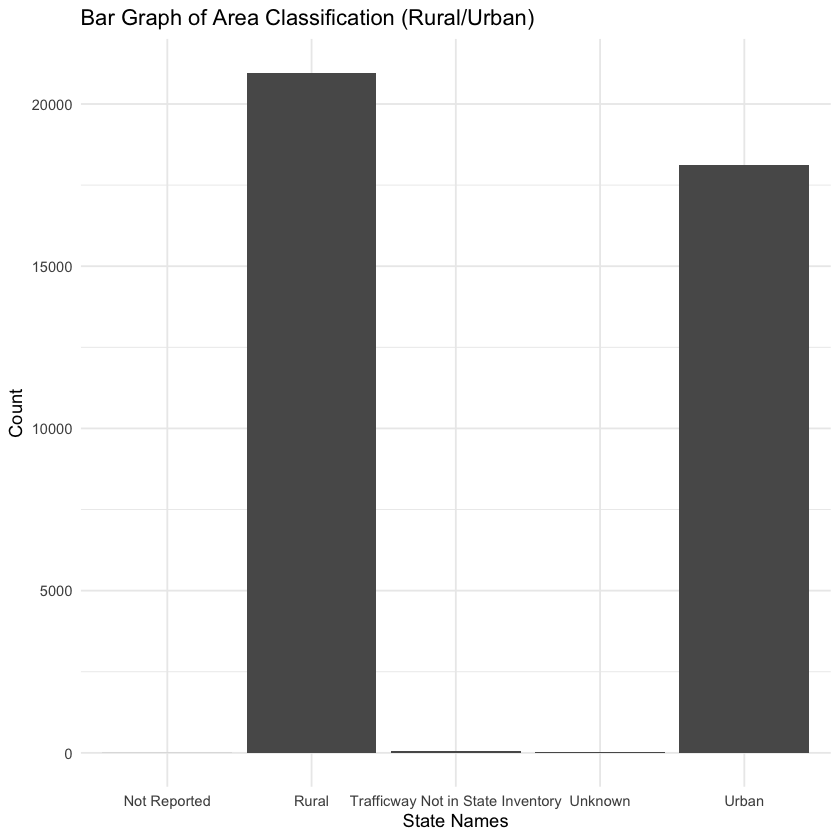

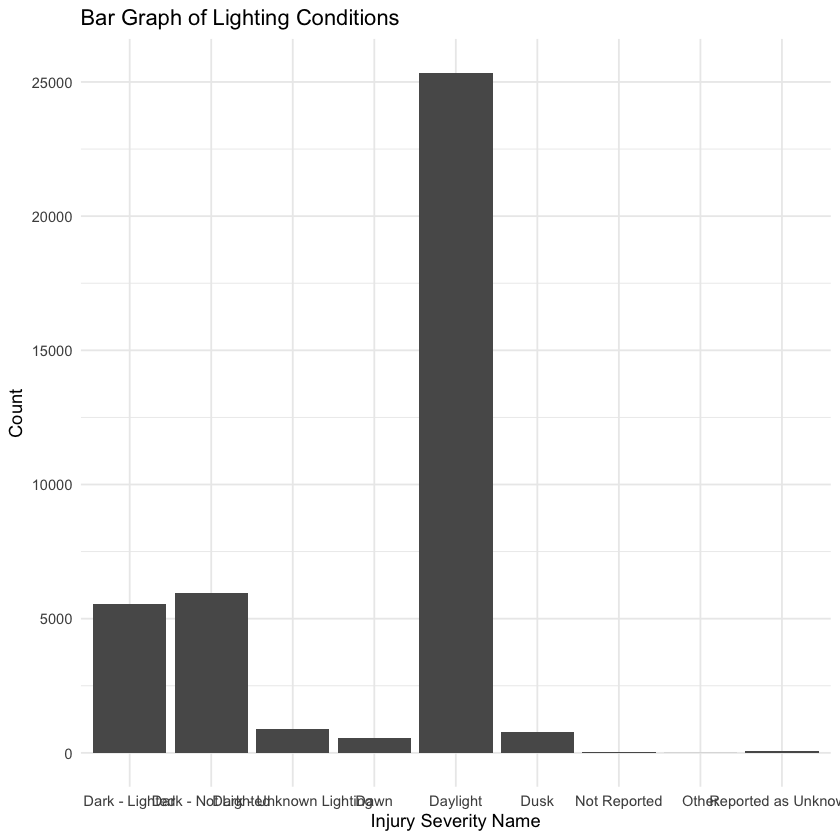

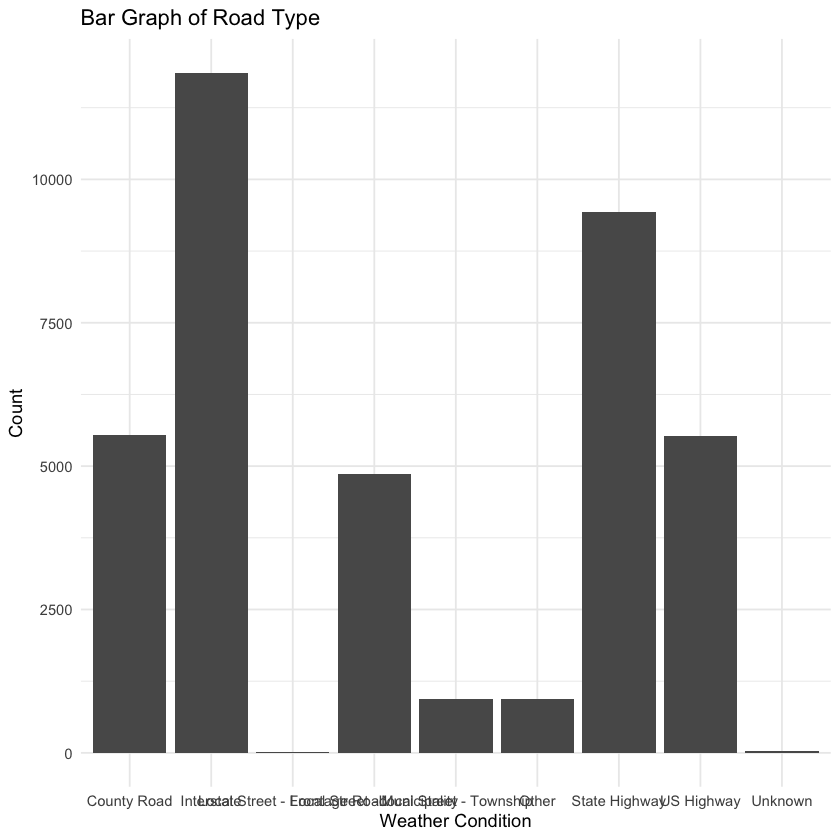

In [5]:
# Box-plots
boxplot(df$FATALS, main="Fatalities Boxplot", ylab="# Fatalities", col = "lightblue")
boxplot(df$TRAV_SP, main="Travel Speed Boxplot", ylab="Speed (mph)", col="lightblue")
boxplot(df$AGE, main="Age of Driver Boxplot", ylab="Age", col="lightblue")
boxplot(df$HOUR.x, main="Hour of Accident", ylab="Hour", col="lightblue")

# Initial Categorical Variable Plots - Bar Graphs
ggplot(df, aes(x = RUR_URBNAME.x)) +
  geom_bar() +
  labs(title = "Bar Graph of Area Classification (Rural/Urban)", x = "State Names", y = "Count") +
  theme_minimal()

ggplot(df, aes(x = LGT_CONDNAME)) +
  geom_bar() +
  labs(title = "Bar Graph of Lighting Conditions", x = "Injury Severity Name", y = "Count") +
  theme_minimal()

ggplot(df, aes(x = ROUTENAME)) +
  geom_bar() +
  labs(title = "Bar Graph of Road Type", x = "Weather Condition", y = "Count") +
  theme_minimal()

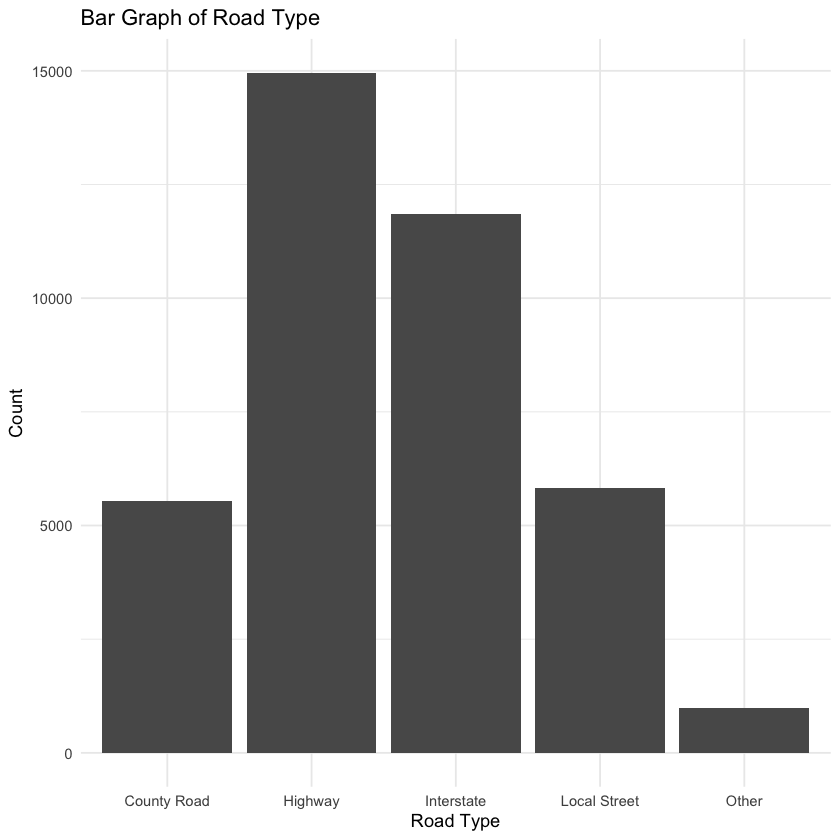

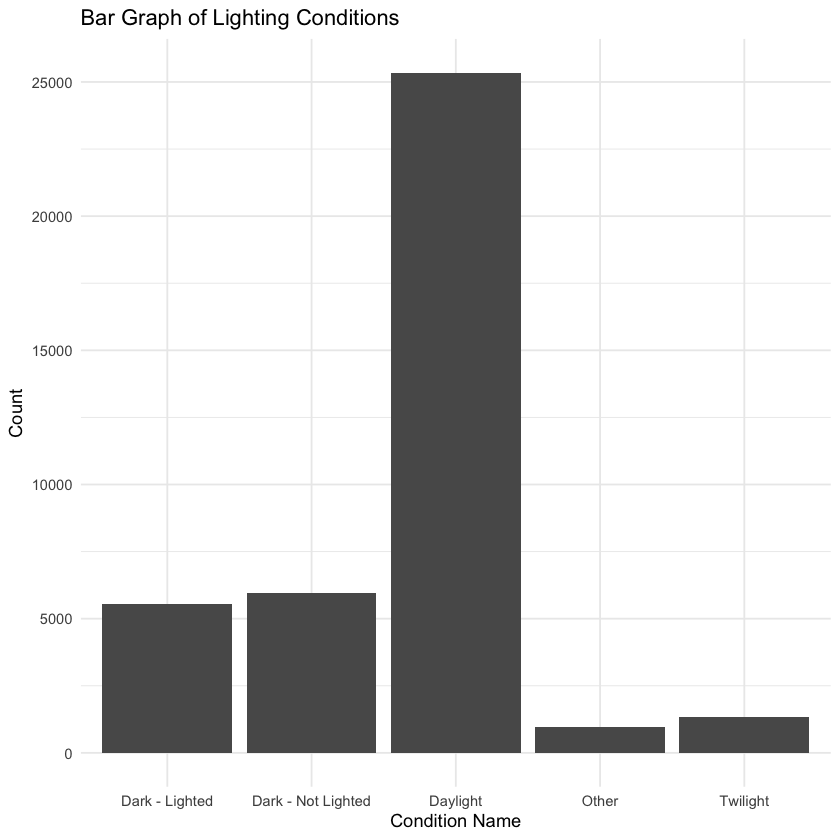

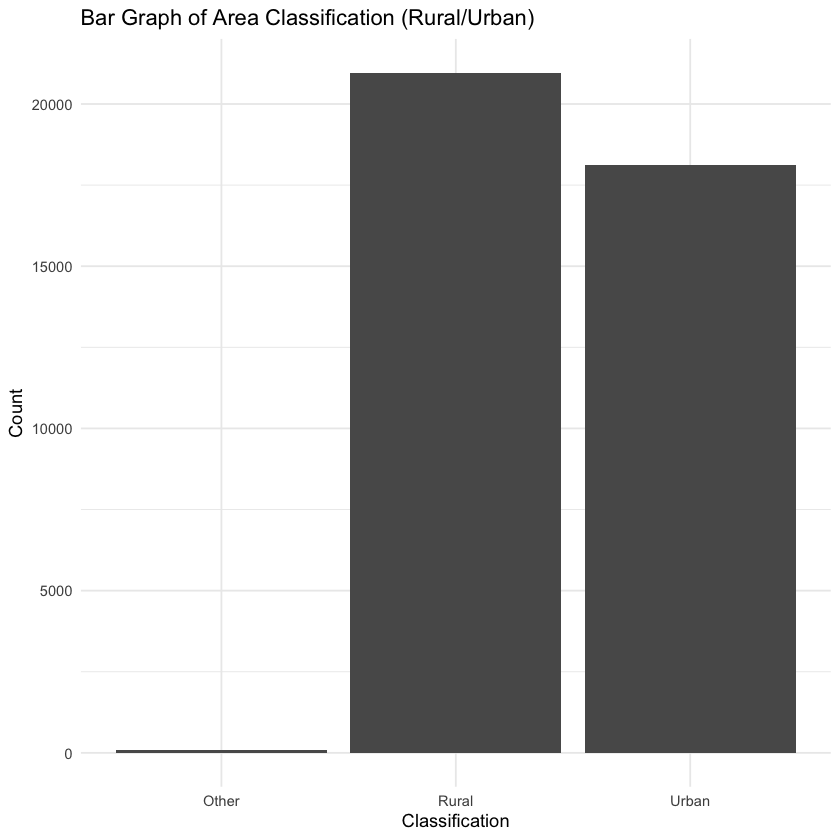

In [6]:
## VARIABLE VALUE CORRECTION - Combine Values for Categorical Variables ##
# ROUTENAME
df <- df %>%
  mutate(RouteCategory = case_when(
    ROUTENAME %in% c("County Road") ~ "County Road",
    ROUTENAME %in% c("Interstate") ~ "Interstate",
    ROUTENAME %in% c("Local Street - Frontage Road", "Local Street - Municipality", "Local Street - Township") ~ "Local Street",
    ROUTENAME %in% c("State Highway", "US Highway") ~ "Highway",
    TRUE ~ "Other"  # Catch-all for "Other" and "Unknown"
  ))

ggplot(df, aes(x = RouteCategory)) +
  geom_bar() +
  labs(title = "Bar Graph of Road Type", x = "Road Type", y = "Count") +
  theme_minimal()

# LGT_CONDNAME
df <- df %>%
  mutate(LightCond = case_when(
    LGT_CONDNAME %in% c("Dark - Lighted") ~ "Dark - Lighted",
    LGT_CONDNAME %in% c("Dark - Not Lighted") ~ "Dark - Not Lighted",
    LGT_CONDNAME %in% c("Daylight") ~ "Daylight",
    LGT_CONDNAME %in% c("Dusk", "Dawn") ~ "Twilight",
    TRUE ~ "Other"  # Catch-all for "Other" and "Unknown"
  ))

ggplot(df, aes(x = LightCond)) +
  geom_bar() +
  labs(title = "Bar Graph of Lighting Conditions", x = "Condition Name", y = "Count") +
  theme_minimal()

# RUR_URBNAME.x
df <- df %>%
  mutate(AreaClass = case_when(
    RUR_URBNAME.x %in% c("Rural") ~ "Rural",
    RUR_URBNAME.x %in% c("Urban") ~ "Urban",
    TRUE ~ "Other"  # Catch-all for "Other" and "Unknown"
  ))

ggplot(df, aes(x = AreaClass)) +
  geom_bar() +
  labs(title = "Bar Graph of Area Classification (Rural/Urban)", x = "Classification", y = "Count") +
  theme_minimal()

In [7]:
## VARIABLE VALUE CORRECTION - Remove Obvious Outliers from Continuous Variables ##
# Filter out rows in all continuous columns where the value is greater than or equal to 997
df_filtered <- df %>% filter(FATALS < 900, TRAV_SP < 900, AGE < 98, HOUR.x <= 24,
  RouteCategory != "Other",
  LightCond != "Other",
  AreaClass != "Other")

# Add sine and cosine transformations of HOUR.x
df_filtered <- df_filtered %>%
  mutate(HOUR_sin = sin(2 * pi * HOUR.x / 24),
         HOUR_cos = cos(2 * pi * HOUR.x / 24))

### Descriptive Statistics for Model Variables

In [49]:
# Summary statistics for continuous variables
summary(df_filtered[, c("FATALS", "TRAV_SP", "AGE", "HOUR.x")])

# Frequency tables for categorical variables
table(df_filtered$RouteCategory)
table(df_filtered$LightCond)
table(df_filtered$AreaClass)

     FATALS         TRAV_SP            AGE            HOUR.x     
 Min.   :1.000   Min.   :  0.00   Min.   : 0.00   Min.   : 0.00  
 1st Qu.:1.000   1st Qu.: 15.00   1st Qu.:22.00   1st Qu.:12.00  
 Median :1.000   Median : 38.00   Median :36.00   Median :12.00  
 Mean   :2.267   Mean   : 36.59   Mean   :37.66   Mean   :12.83  
 3rd Qu.:4.000   3rd Qu.: 55.00   3rd Qu.:53.00   3rd Qu.:16.00  
 Max.   :4.000   Max.   :140.00   Max.   :96.00   Max.   :23.00  


 County Road      Highway   Interstate Local Street 
        1643         4643         8091         1161 


    Dark - Lighted Dark - Not Lighted           Daylight           Twilight 
              1347               1893              11941                357 


Rural Urban 
10421  5117 

### Correlation Matrix

In [8]:
## SHOW CORRELATION ##
# Correlation Matrix for Continuous
subset_df <- df[c("FATALS", "TRAV_SP", "AGE", "HOUR.x")]
cor_matrix_sub <- cor(subset_df)
print(cor_matrix_sub)

             FATALS     TRAV_SP         AGE      HOUR.x
FATALS   1.00000000 -0.42690018 -0.09367553 -0.09172804
TRAV_SP -0.42690018  1.00000000  0.07637953  0.06279095
AGE     -0.09367553  0.07637953  1.00000000  0.02792726
HOUR.x  -0.09172804  0.06279095  0.02792726  1.00000000


### Heatmaps

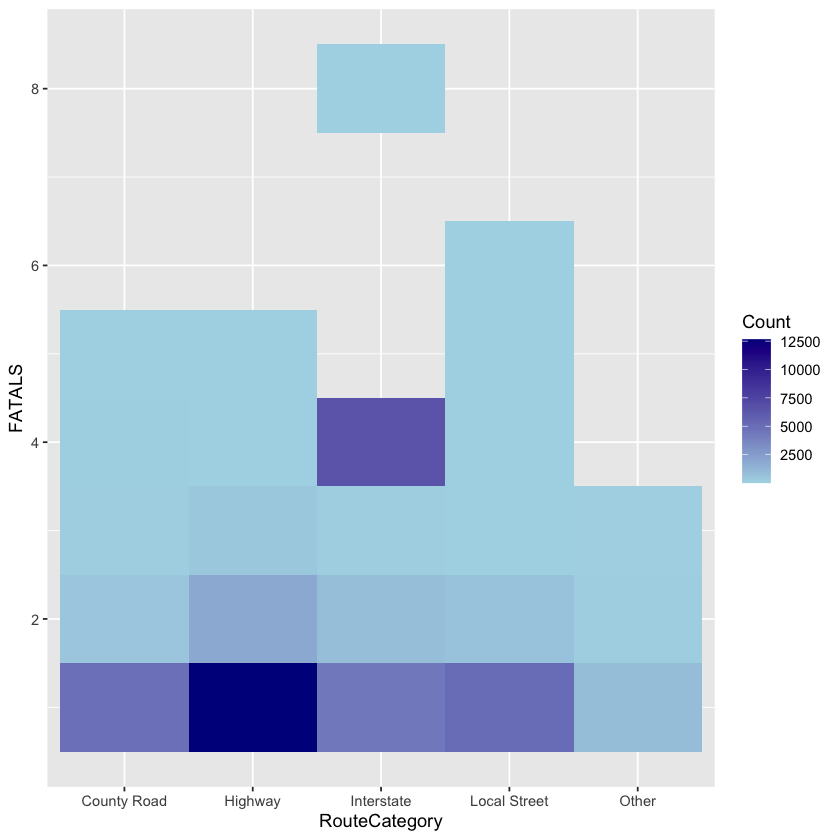

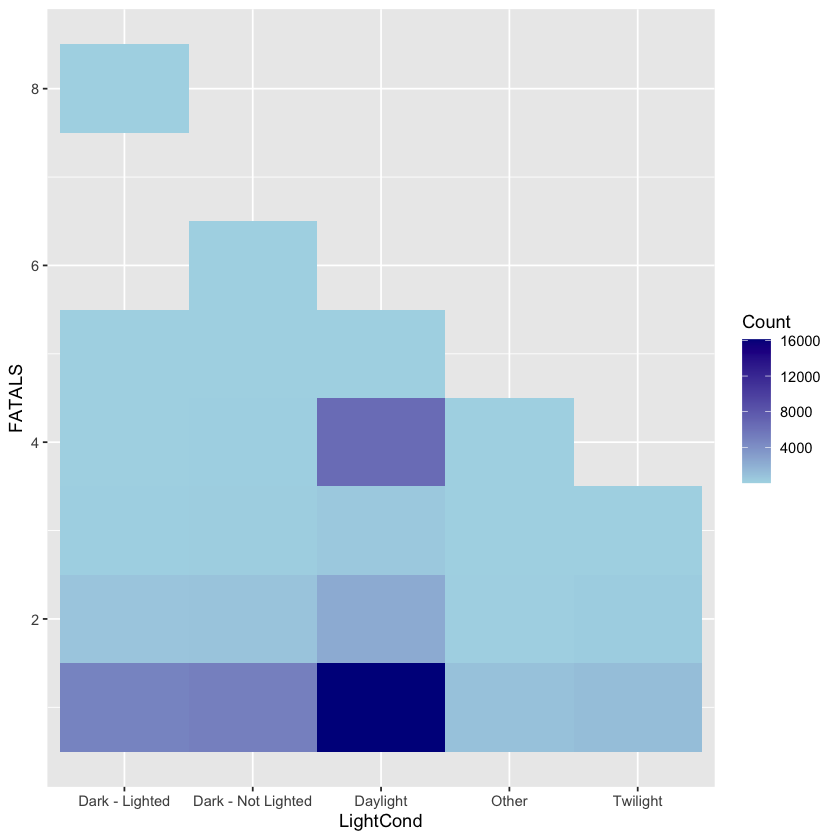

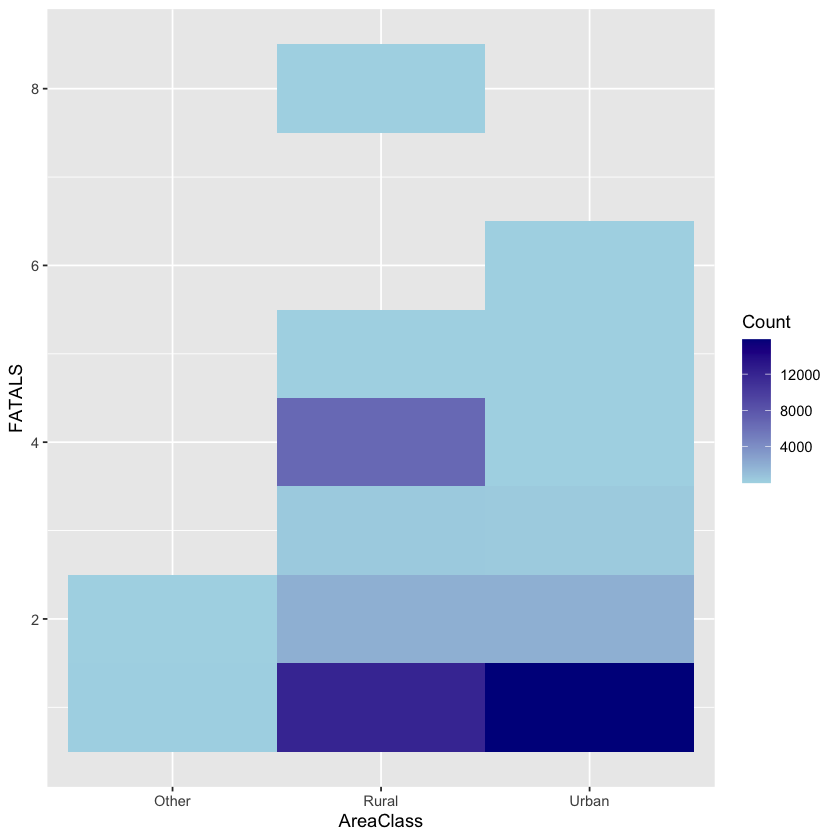

In [9]:
# Heat Maps for Categoricals
# Route x Fatalities
route_fatals_counts <- df %>%
  count(RouteCategory, FATALS)

ggplot(route_fatals_counts, aes(x = RouteCategory, y = FATALS, fill = n)) +
  geom_tile() +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  labs(fill = "Count")

# Lighting Conditions x Fatalities
light_fatals_counts <- df %>%
  count(LightCond, FATALS)

ggplot(light_fatals_counts, aes(x = LightCond, y = FATALS, fill = n)) +
  geom_tile() +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  labs(fill = "Count")

# Area Classification x Fatalities
area_fatals_counts <- df %>%
  count(AreaClass, FATALS)

ggplot(area_fatals_counts, aes(x = AreaClass, y = FATALS, fill = n)) +
  geom_tile() +
  scale_fill_gradient(low = "lightblue", high = "darkblue") +
  labs(fill = "Count")

### Descriptive Statistics for Model Variables

### Initial Model 


Call:
lm(formula = FATALS ~ RouteCategory + LightCond + AreaClass + 
    TRAV_SP + AGE + HOUR.x, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.6994 -0.6349  0.3089  0.5433  2.9080 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  2.0121843  0.0451480  44.569  < 2e-16 ***
RouteCategoryHighway        -0.1224755  0.0245812  -4.982 6.34e-07 ***
RouteCategoryInterstate      1.4609963  0.0243334  60.041  < 2e-16 ***
RouteCategoryLocal Street    0.1770809  0.0336315   5.265 1.42e-07 ***
LightCondDark - Not Lighted -0.5059909  0.0323295 -15.651  < 2e-16 ***
LightCondDaylight            0.2368556  0.0273572   8.658  < 2e-16 ***
LightCondTwilight           -0.4080810  0.0513890  -7.941 2.14e-15 ***
AreaClassUrban              -0.9868094  0.0173365 -56.921  < 2e-16 ***
TRAV_SP                     -0.0008901  0.0002828  -3.147  0.00165 ** 
AGE                         -0.0061455  0.0003441 -17.857  < 2e

[1] 39109.07

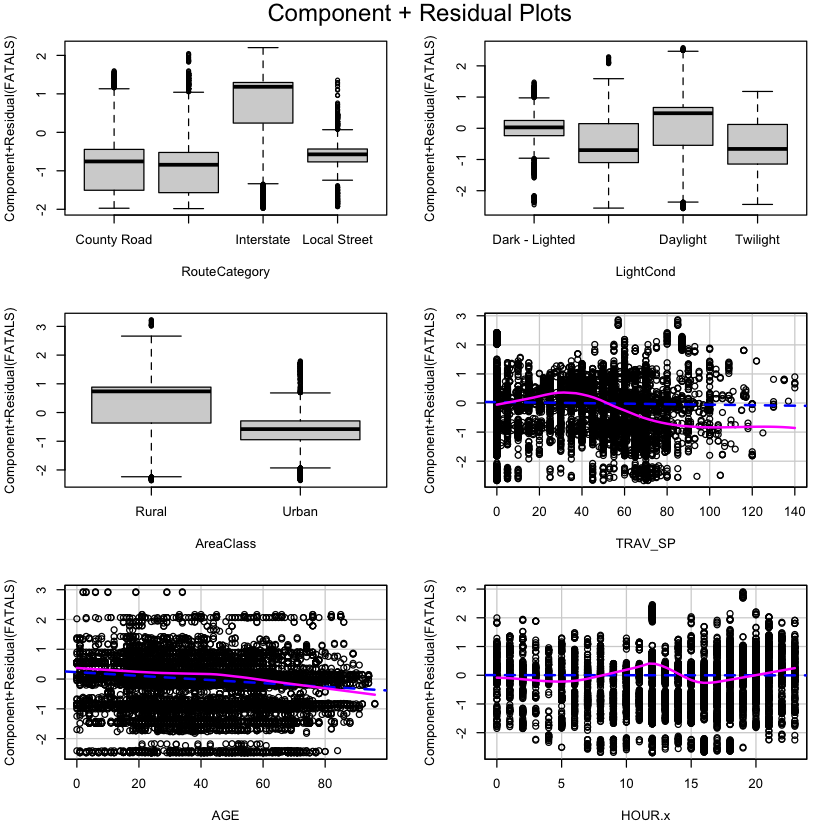

In [13]:
## RESIDUAL PLOTS ##
# Convert categorical variables to dummies
df_filtered$RouteCategory <- factor(df_filtered$RouteCategory)
df_filtered$LightCond <- factor(df_filtered$LightCond)
df_filtered$AreaClass <- factor(df_filtered$AreaClass)

model <- lm(FATALS ~ RouteCategory + LightCond + AreaClass + TRAV_SP + AGE + HOUR.x, data = df_filtered)

summary(model)
AIC(model)
crPlots(model)


Call:
lm(formula = FATALS ~ RouteCategory + LightCond + AreaClass + 
    poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7352 -0.4896  0.2740  0.4693  2.7369 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   2.26006    0.03485  64.844  < 2e-16 ***
RouteCategoryHighway         -0.11552    0.02286  -5.054 4.38e-07 ***
RouteCategoryInterstate       1.25415    0.02311  54.272  < 2e-16 ***
RouteCategoryLocal Street     0.15550    0.03128   4.972 6.70e-07 ***
LightCondDark - Not Lighted  -0.50060    0.03008 -16.642  < 2e-16 ***
LightCondDaylight            -0.98331    0.03709 -26.511  < 2e-16 ***
LightCondTwilight            -0.85649    0.04872 -17.581  < 2e-16 ***
AreaClassUrban               -0.80184    0.01660 -48.316  < 2e-16 ***
poly(TRAV_SP, 2)1            -0.32469    0.82956  -0.391    0.696    
poly(TRAV_SP, 2)2           -12.79824    0

[1] 36845.7

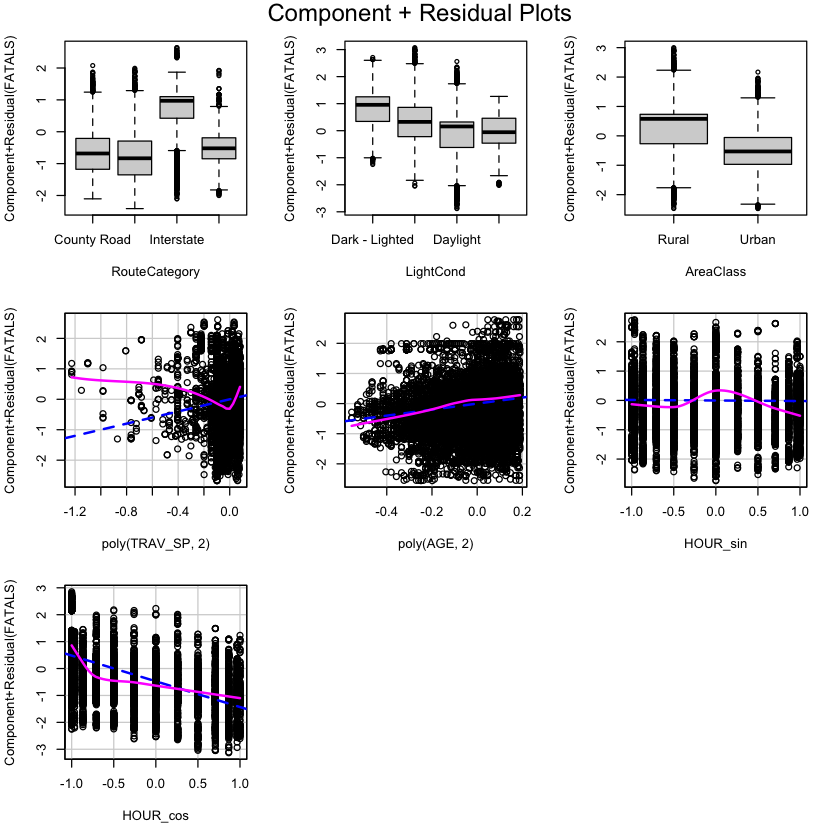

In [14]:
# transforming TRAV_SP and AGE to address linearity
model2 <- lm(FATALS ~ RouteCategory + LightCond + AreaClass + poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos,  data = df_filtered)
summary(model2)
AIC(model2)
crPlots(model2)

In [17]:
# using stepwise selection
stepwise_model <- stepAIC(model2, direction = "both")
summary(stepwise_model)

Start:  AIC=-7251.24
FATALS ~ RouteCategory + LightCond + AreaClass + poly(TRAV_SP, 
    2) + poly(AGE, 2) + HOUR_sin + HOUR_cos



                   Df Sum of Sq     RSS     AIC
<none>                           9726.1 -7251.2
- HOUR_sin          1       1.6  9727.7 -7250.7
- poly(TRAV_SP, 2)  2     148.8  9874.8 -7019.3
- poly(AGE, 2)      2     298.2 10024.3 -6786.0
- LightCond         3     470.5 10196.6 -6523.2
- HOUR_cos          1    1232.3 10958.4 -5399.6
- AreaClass         1    1462.6 11188.7 -5076.5
- RouteCategory     3    4736.8 14462.9 -1092.1



Call:
lm(formula = FATALS ~ RouteCategory + LightCond + AreaClass + 
    poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7352 -0.4896  0.2740  0.4693  2.7369 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   2.26006    0.03485  64.844  < 2e-16 ***
RouteCategoryHighway         -0.11552    0.02286  -5.054 4.38e-07 ***
RouteCategoryInterstate       1.25415    0.02311  54.272  < 2e-16 ***
RouteCategoryLocal Street     0.15550    0.03128   4.972 6.70e-07 ***
LightCondDark - Not Lighted  -0.50060    0.03008 -16.642  < 2e-16 ***
LightCondDaylight            -0.98331    0.03709 -26.511  < 2e-16 ***
LightCondTwilight            -0.85649    0.04872 -17.581  < 2e-16 ***
AreaClassUrban               -0.80184    0.01660 -48.316  < 2e-16 ***
poly(TRAV_SP, 2)1            -0.32469    0.82956  -0.391    0.696    
poly(TRAV_SP, 2)2           -12.79824    0

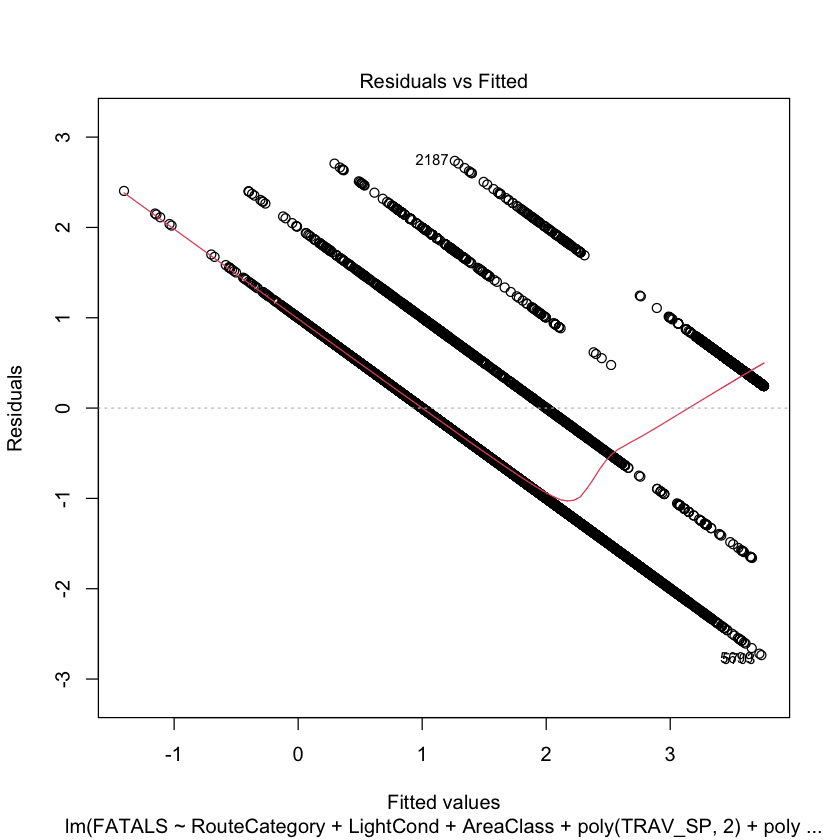

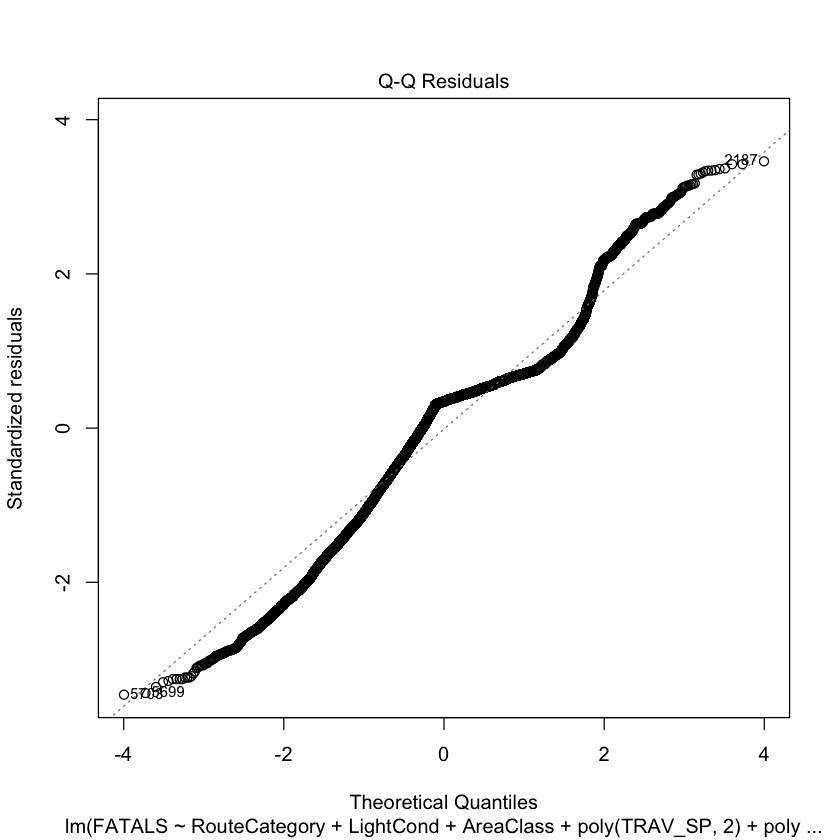

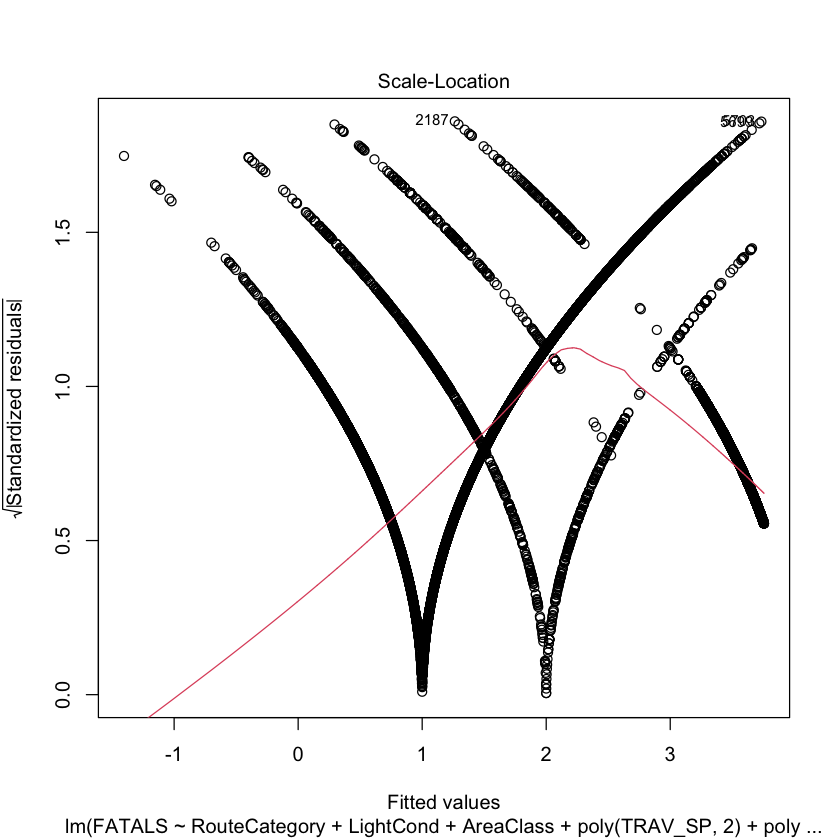

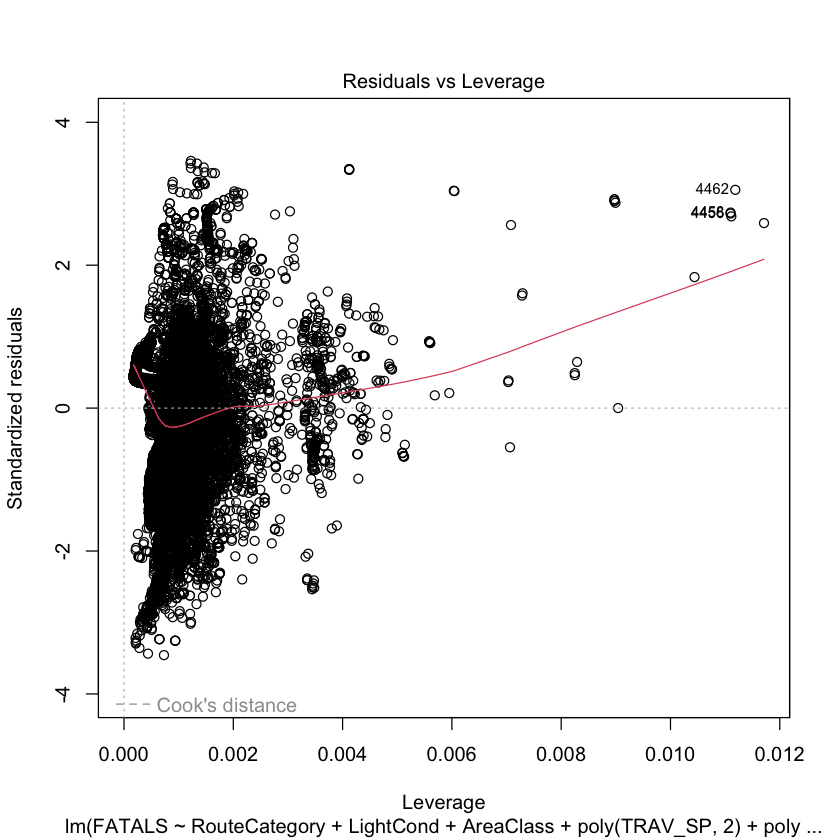

In [18]:
plot(model2)


Call:
lm(formula = FATALS ~ RouteCategory * LightCond + AreaClass + 
    poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7864 -0.3646  0.2250  0.3916  2.6909 

Coefficients:
                                                       Estimate Std. Error
(Intercept)                                             2.19268    0.05880
RouteCategoryHighway                                    0.16217    0.06633
RouteCategoryInterstate                                 0.10730    0.07192
RouteCategoryLocal Street                               0.17230    0.06661
LightCondDark - Not Lighted                            -0.33378    0.07230
LightCondDaylight                                      -0.94995    0.06550
LightCondTwilight                                      -0.52109    0.09750
AreaClassUrban                                         -0.71361    0.01593
poly(TRAV_SP, 2)1                                      -0.12901    

[1] 35068.78

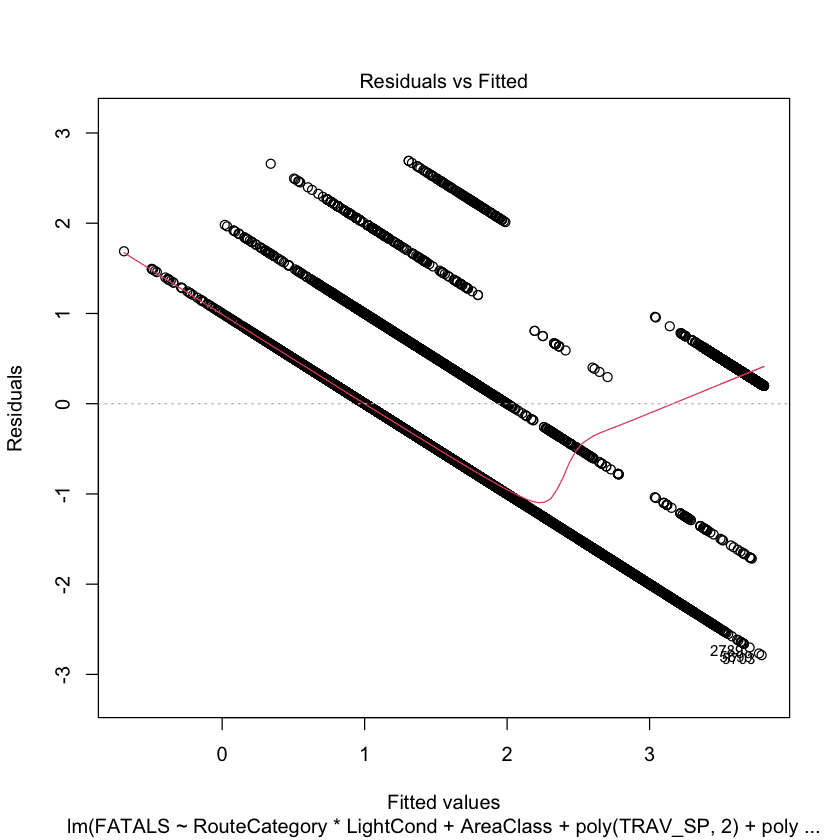

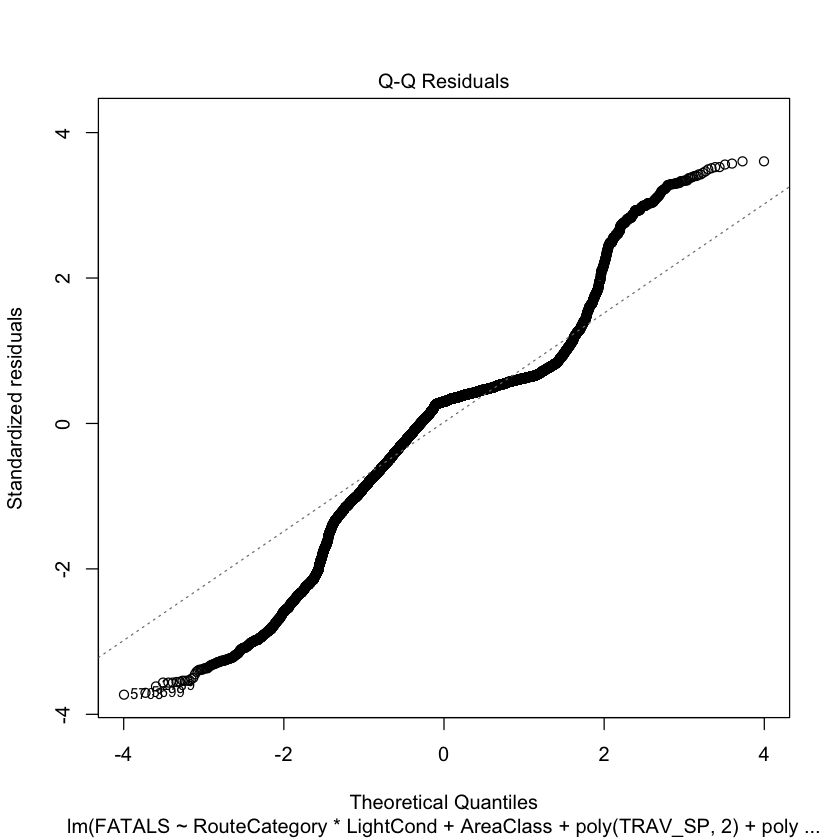

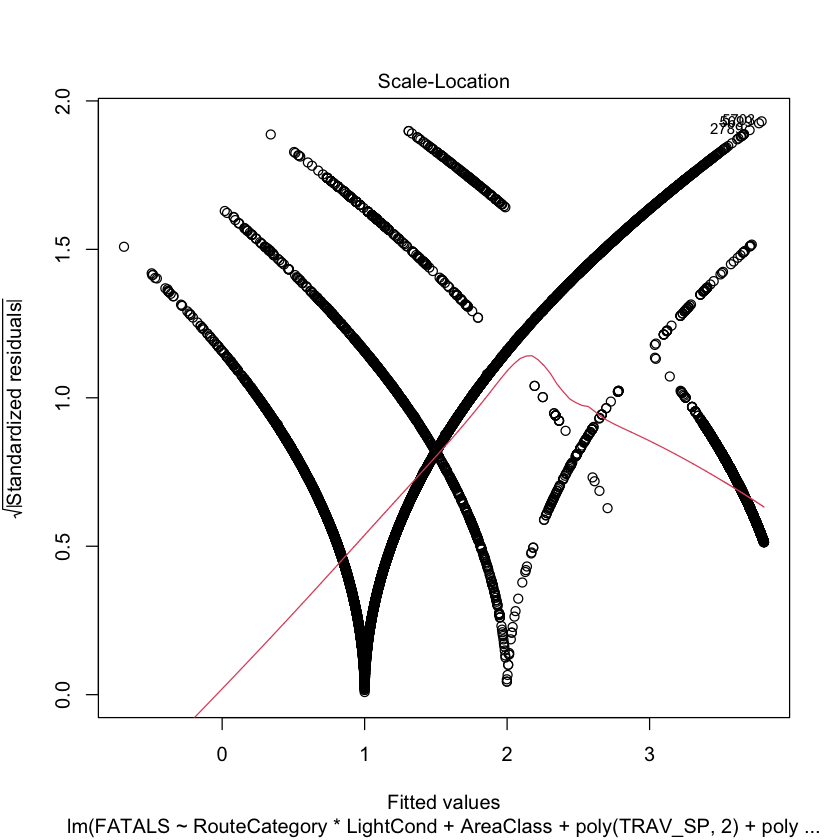

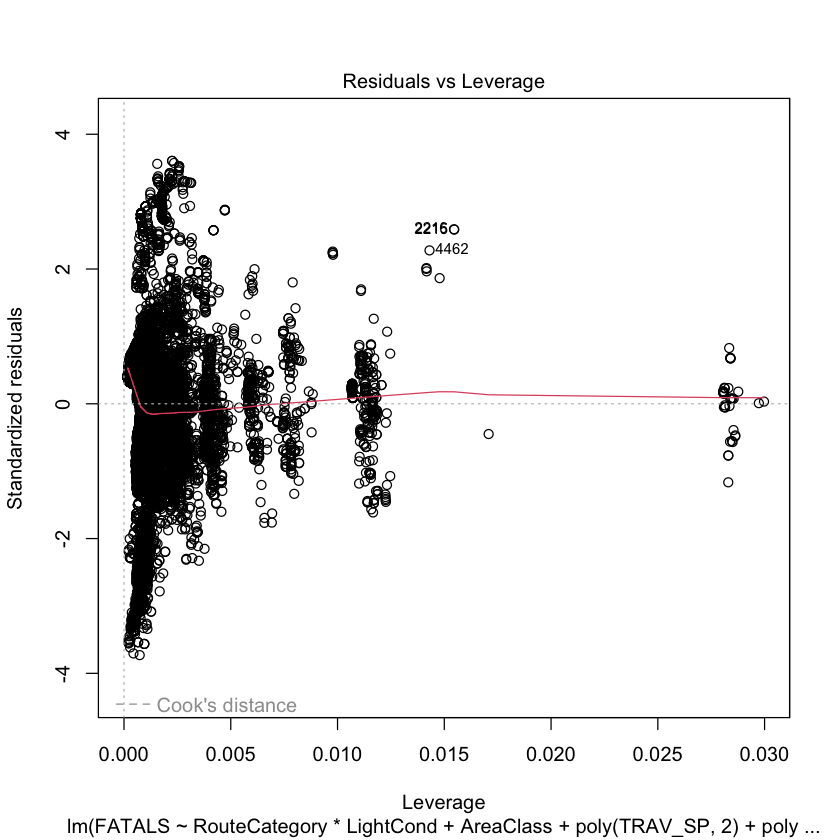

In [20]:
# using interaction terms to improve fit
model3 <- lm(FATALS ~ RouteCategory * LightCond + AreaClass + 
                        poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, 
                        data = df_filtered)
summary(model3)
AIC(model3)
plot(model3)

In [21]:
# using stepwise selection for model with interaction term
stepwise_model2 <- stepAIC(model3, direction = "both")
summary(stepwise_model2)

Start:  AIC=-9028.16
FATALS ~ RouteCategory * LightCond + AreaClass + poly(TRAV_SP, 
    2) + poly(AGE, 2) + HOUR_sin + HOUR_cos

                          Df Sum of Sq    RSS     AIC
<none>                                 8665.0 -9028.2
- HOUR_sin                 1      3.78 8668.8 -9023.4
- poly(TRAV_SP, 2)         2     86.16 8751.1 -8878.4
- poly(AGE, 2)             2    183.98 8849.0 -8705.7
- HOUR_cos                 1    730.37 9395.4 -7772.7
- RouteCategory:LightCond  9   1061.07 9726.1 -7251.2
- AreaClass                1   1120.92 9785.9 -7139.9



Call:
lm(formula = FATALS ~ RouteCategory * LightCond + AreaClass + 
    poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7864 -0.3646  0.2250  0.3916  2.6909 

Coefficients:
                                                       Estimate Std. Error
(Intercept)                                             2.19268    0.05880
RouteCategoryHighway                                    0.16217    0.06633
RouteCategoryInterstate                                 0.10730    0.07192
RouteCategoryLocal Street                               0.17230    0.06661
LightCondDark - Not Lighted                            -0.33378    0.07230
LightCondDaylight                                      -0.94995    0.06550
LightCondTwilight                                      -0.52109    0.09750
AreaClassUrban                                         -0.71361    0.01593
poly(TRAV_SP, 2)1                                      -0.12901    

### Poisson Model


Call:
glm(formula = FATALS ~ RouteCategory * LightCond + AreaClass + 
    poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, family = poisson(link = "log"), 
    data = df_filtered)

Coefficients:
                                                      Estimate Std. Error
(Intercept)                                            0.70721    0.07449
RouteCategoryHighway                                   0.13230    0.08337
RouteCategoryInterstate                                0.07095    0.09229
RouteCategoryLocal Street                              0.12616    0.08543
LightCondDark - Not Lighted                           -0.17307    0.09151
LightCondDaylight                                     -0.55142    0.08235
LightCondTwilight                                     -0.31361    0.12535
AreaClassUrban                                        -0.40971    0.01771
poly(TRAV_SP, 2)1                                      0.35313    0.81042
poly(TRAV_SP, 2)2                                     -3.1

Pseudo R^2:  0.7537667 


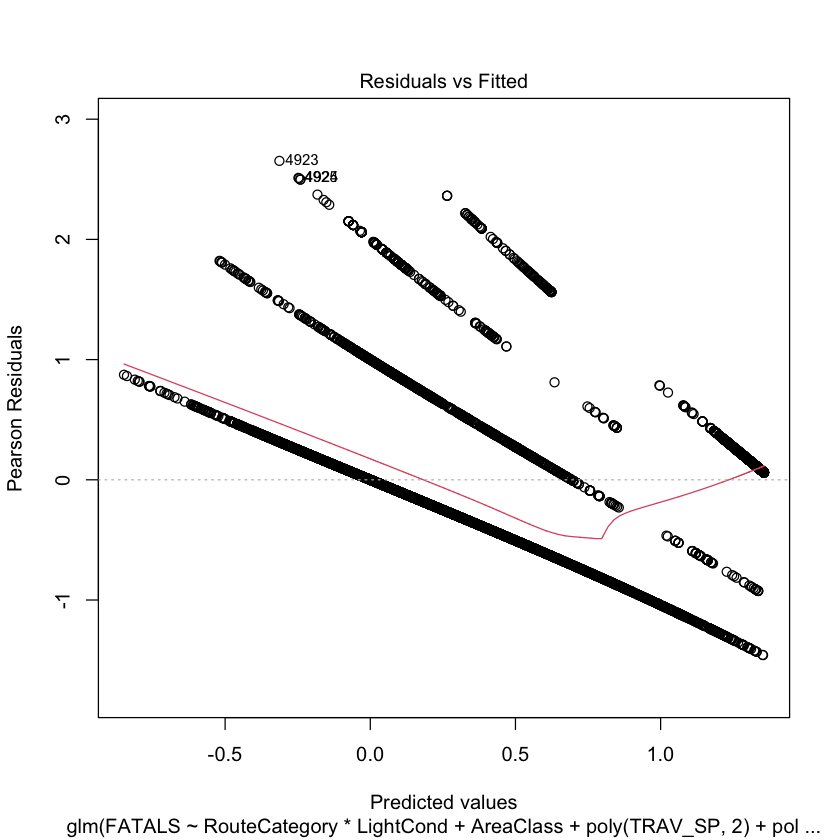

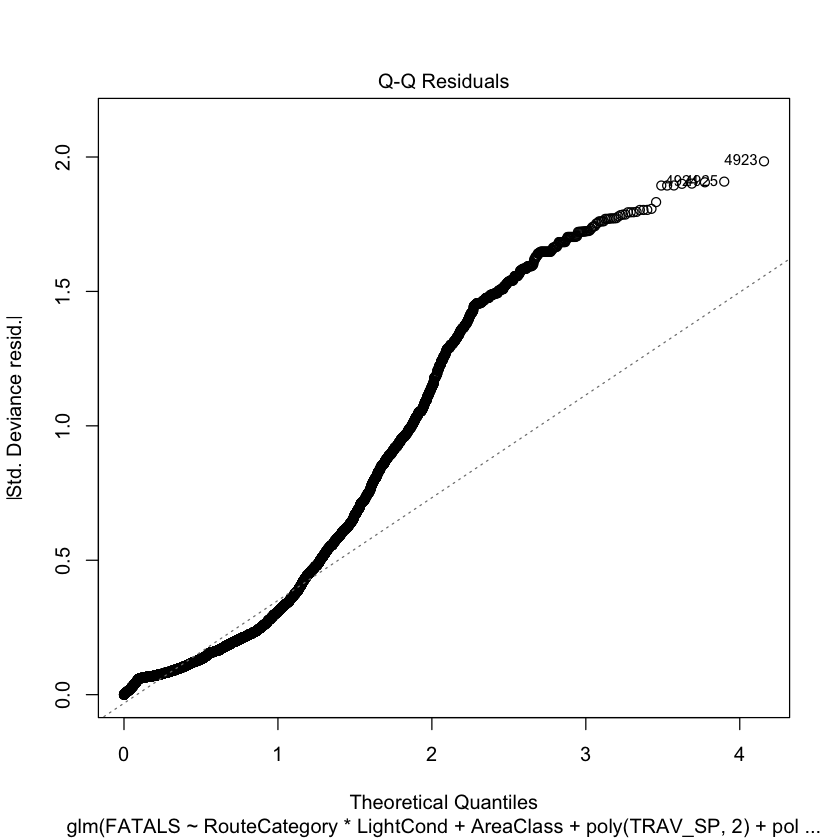

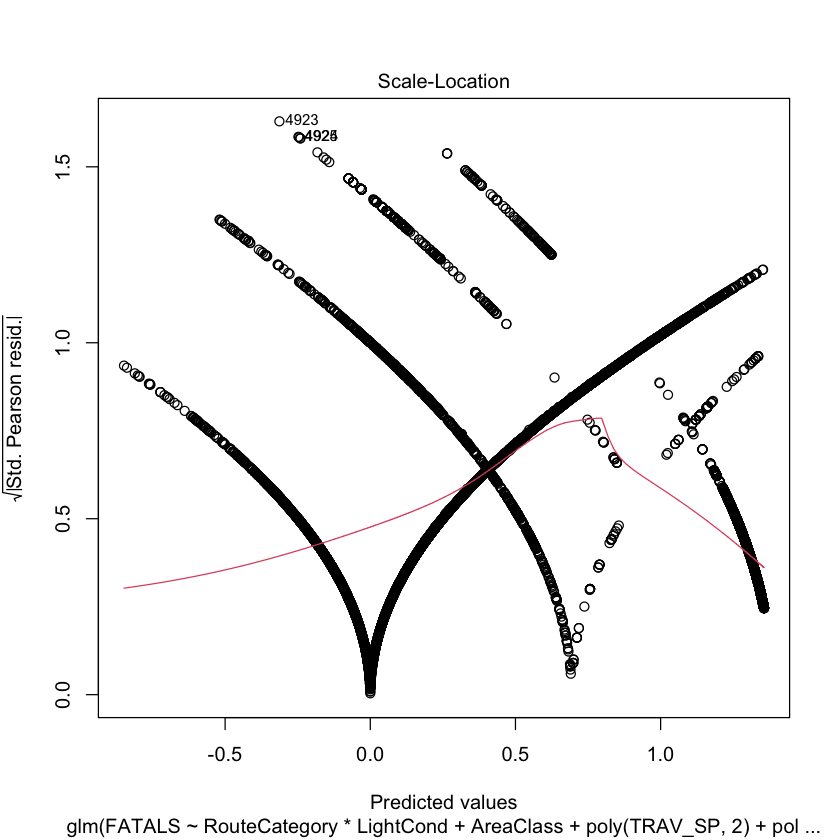

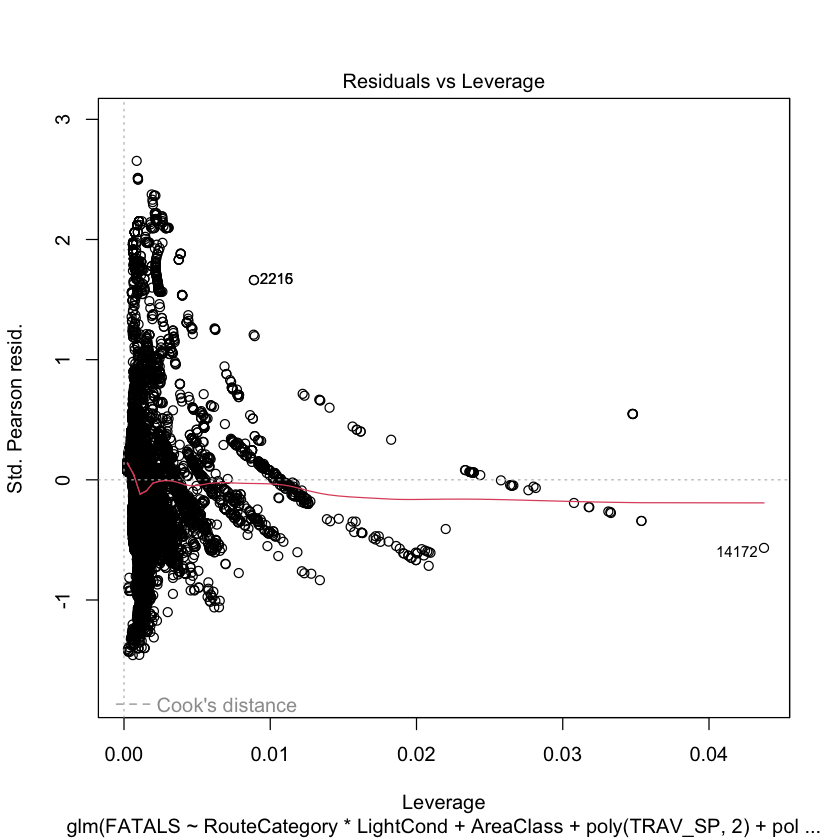

In [29]:
# Poisson Regression Model
poisson_model <- glm(FATALS ~ RouteCategory * LightCond + AreaClass + 
                    poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos,  
                    family = poisson(link = "log"), data = df_filtered)
summary(poisson_model)

# calculate pseudo r^2
null_deviance <- poisson_model$null.deviance
residual_deviance <- poisson_model$deviance
pseudo_r2 <- 1 - (residual_deviance / null_deviance)
cat("Pseudo R^2: ", pseudo_r2, "\n")

plot(poisson_model)

### Model Diagnostics: Multicollinearity and Influence Analysis

In [52]:
vif_values <- vif(model3)
print(vif_values)

there are higher-order terms (interactions) in this model
consider setting type = 'predictor'; see ?vif



                                GVIF Df GVIF^(1/(2*Df))
RouteCategory             646.722811  3        2.940716
LightCond                 319.767755  3        2.615005
AreaClass                   1.559132  1        1.248652
poly(TRAV_SP, 2)            1.239415  2        1.055126
poly(AGE, 2)                1.093818  2        1.022672
HOUR_sin                    1.111652  1        1.054349
HOUR_cos                    5.272389  1        2.296168
RouteCategory:LightCond 33749.728108  9        1.784722


,StudRes,Hat,CookD
,<dbl>,<dbl>,<dbl>
1382,0.032866333,0.0299726795,1.451257e-06
1383,0.009071465,0.0297314699,1.096426e-07
2215,2.585194651,0.0154666696,4.563163e-03
2216,2.590542606,0.0154544406,4.578374e-03
5699,-3.706019895,0.0004425951,2.641984e-04
5703,-3.731370799,0.0007353339,4.450937e-04


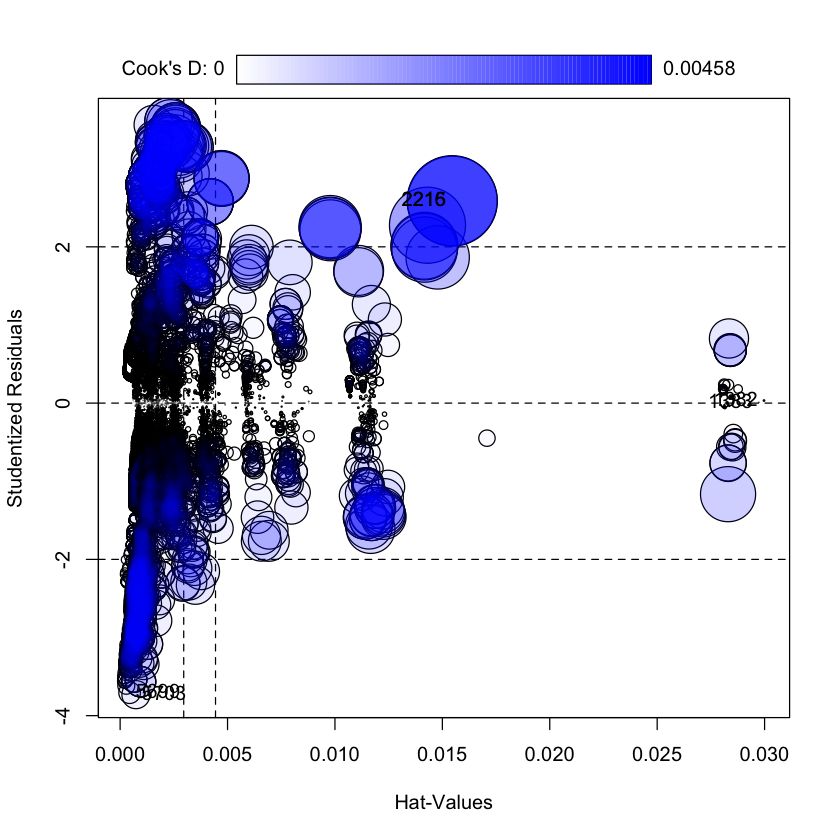

In [32]:
influencePlot(model3)

### Model Evaluation and Validation

In [48]:
# comparing AIC of all linear models
AIC(model, model2, model3, poisson_model)

,df,AIC
,<dbl>,<dbl>
model,12,39109.07
model2,15,36845.70
model3,24,35068.78
poisson_model,23,43097.43


In [33]:
# Predictions
df_filtered$predicted <- predict(model3, type = "response")

# Calculate MSE and MAE
mse <- mean((df_filtered$FATALS - df_filtered$predicted)^2)
mae <- mean(abs(df_filtered$FATALS - df_filtered$predicted))
cat("Mean Squared Error (MSE): ", mse, "\n")
cat("Mean Absolute Error (MAE): ", mae, "\n")

Mean Squared Error (MSE):  0.5576645 
Mean Absolute Error (MAE):  0.5472443 


In [34]:
# Split data into training and testing sets (70/30 split)
set.seed(123)  # For reproducibility
train_indices <- sample(1:nrow(df_filtered), size = 0.7 * nrow(df_filtered))
train_data <- df_filtered[train_indices, ]
test_data <- df_filtered[-train_indices, ]

# Fit model on training data
train_model <- lm(FATALS ~ RouteCategory * LightCond + AreaClass + 
                        poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, 
                        data = df_filtered)

# Predict on test data
test_data$predicted <- predict(train_model, newdata = test_data, type = "response")

# Calculate test MSE and MAE
test_mse <- mean((test_data$FATALS - test_data$predicted)^2)
test_mae <- mean(abs(test_data$FATALS - test_data$predicted))
cat("Test Mean Squared Error (MSE): ", test_mse, "\n")
cat("Test Mean Absolute Error (MAE): ", test_mae, "\n")

# Compare train vs. test errors
cat("Train/Test Error Ratio (MSE): ", mse / test_mse, "\n")

Test Mean Squared Error (MSE):  0.5479121 
Test Mean Absolute Error (MAE):  0.5424467 
Train/Test Error Ratio (MSE):  1.017799 


### Final Model

In [54]:
final_model <- model3
summary(final_model)


Call:
lm(formula = FATALS ~ RouteCategory * LightCond + AreaClass + 
    poly(TRAV_SP, 2) + poly(AGE, 2) + HOUR_sin + HOUR_cos, data = df_filtered)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.7864 -0.3646  0.2250  0.3916  2.6909 

Coefficients:
                                                       Estimate Std. Error
(Intercept)                                             2.19268    0.05880
RouteCategoryHighway                                    0.16217    0.06633
RouteCategoryInterstate                                 0.10730    0.07192
RouteCategoryLocal Street                               0.17230    0.06661
LightCondDark - Not Lighted                            -0.33378    0.07230
LightCondDaylight                                      -0.94995    0.06550
LightCondTwilight                                      -0.52109    0.09750
AreaClassUrban                                         -0.71361    0.01593
poly(TRAV_SP, 2)1                                      -0.12901    

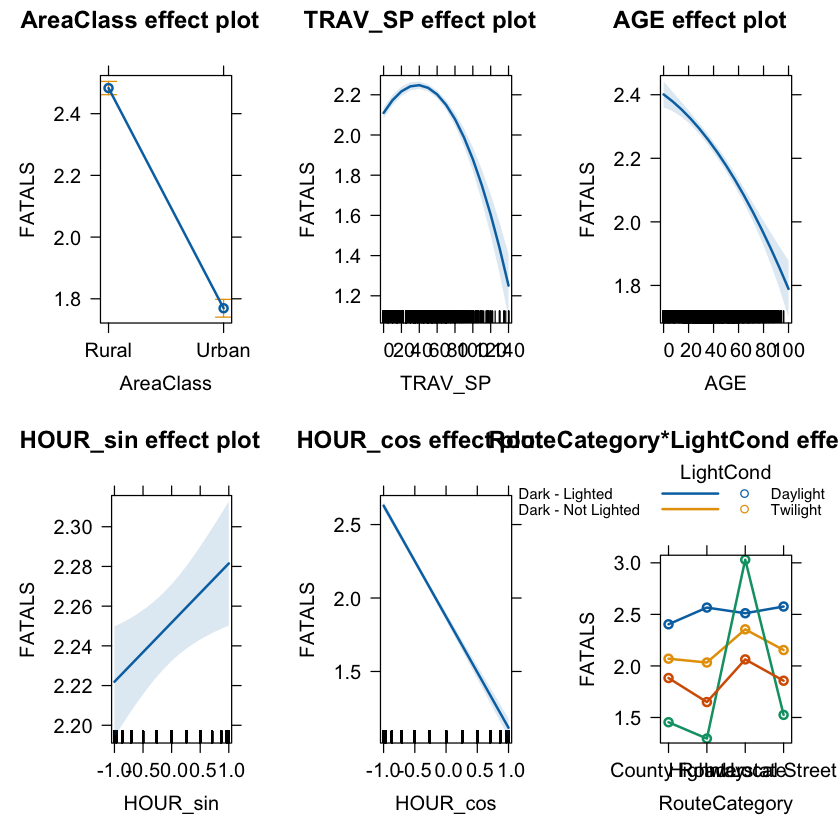

In [61]:
plot(allEffects(final_model), multiline = TRUE)